In [1]:
# Sean Nicolai
# A.I. in Healthcare
# 02/03/25
# https://github.com/SeanNicolai/A.I.-in-Healthcare/blob/main/MIMICVisualization.ipynb

In [2]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dateutil.relativedelta import relativedelta

In [3]:
# =========================
# Load datasets
# =========================
# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the MIMIC folder
mimic_path = "/content/drive/MyDrive/MIMIC/"

# Load datasets
PATIENTS = pd.read_csv(mimic_path + "PATIENTS.csv.gz")
ADMISSIONS = pd.read_csv(mimic_path + "ADMISSIONS.csv.gz")
DIAGNOSES = pd.read_csv(mimic_path + "DIAGNOSES_ICD.csv.gz")
ICU = pd.read_csv(mimic_path + "ICUSTAYS.csv.gz")
PRESCRIPTIONS = pd.read_csv(mimic_path + "PRESCRIPTIONS.csv.gz")

Mounted at /content/drive


<ipython-input-3-c957cce78a96>:15: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  PRESCRIPTIONS = pd.read_csv(mimic_path + "PRESCRIPTIONS.csv.gz")


In [4]:
# =========================
# Data Preprocessing
# =========================
# Convert date columns to datetime format
for col in ['DOB', 'DOD']:
    PATIENTS[col] = pd.to_datetime(PATIENTS[col], errors='coerce')
ADMISSIONS['ADMITTIME'] = pd.to_datetime(ADMISSIONS['ADMITTIME'], errors='coerce')
ICU['INTIME'] = pd.to_datetime(ICU['INTIME'], errors='coerce')
ICU['OUTTIME'] = pd.to_datetime(ICU['OUTTIME'], errors='coerce')

# Handle missing or invalid dates
REFERENCE_DATE = pd.to_datetime('2100-01-01')
PATIENTS.loc[PATIENTS['DOD'].isna(), 'DOD'] = REFERENCE_DATE
PATIENTS = PATIENTS.dropna(subset=['DOB'])
PATIENTS = PATIENTS[PATIENTS['DOB'] < REFERENCE_DATE]

# Compute age
PATIENTS['AGE'] = PATIENTS.apply(lambda row: relativedelta(row['DOD'], row['DOB']).years, axis=1)
PATIENTS = PATIENTS[(PATIENTS['AGE'] > 0) & (PATIENTS['AGE'] < 120)]

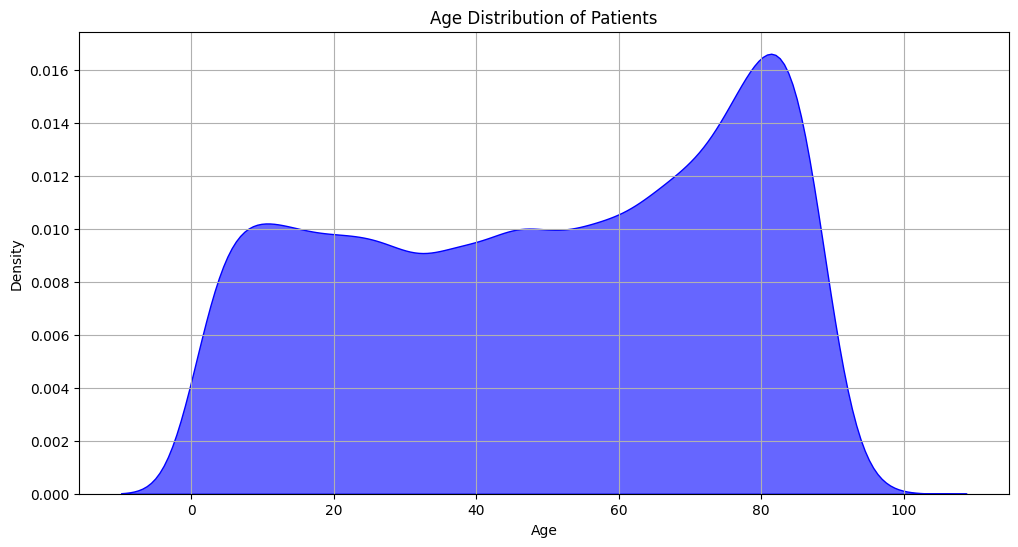

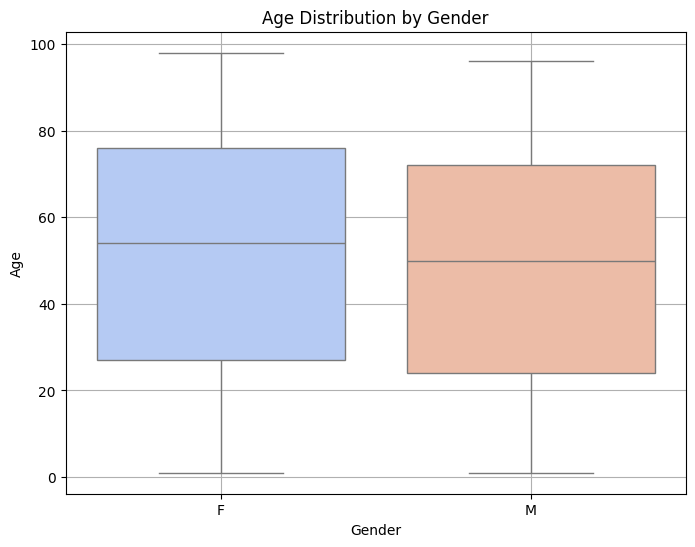

In [5]:
# =========================
# 1. Age Distribution of Patients
# =========================
plt.figure(figsize=(12, 6))
sns.kdeplot(PATIENTS['AGE'], fill=True, color='blue', alpha=0.6)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Density')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='GENDER', y='AGE', data=PATIENTS, hue='GENDER', palette='coolwarm')
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.grid(True)
plt.show()

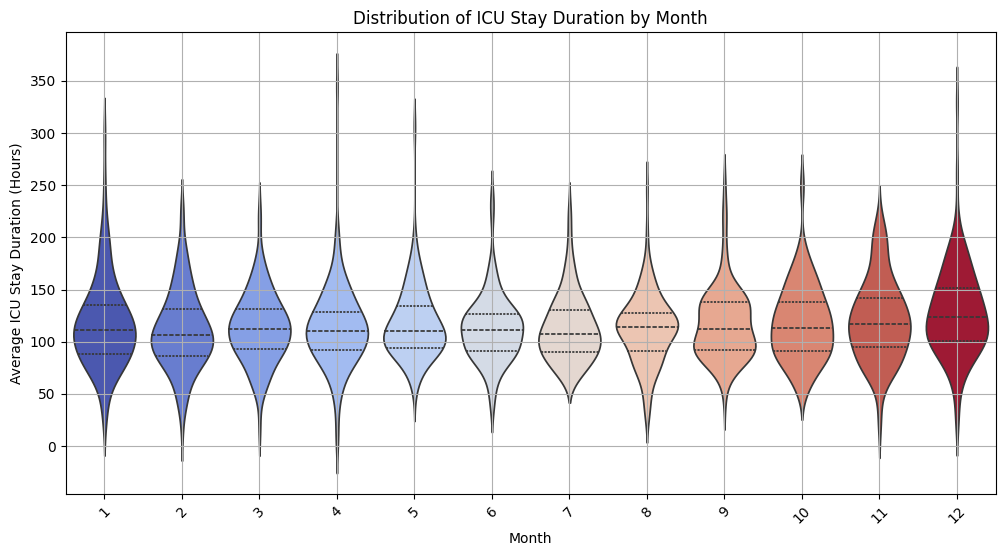

In [6]:
# =========================
# 2. ICU Admissions Over Time
# =========================
ICU['DURATION_HOURS'] = (ICU['OUTTIME'] - ICU['INTIME']).dt.total_seconds() / 3600
ICU_ADMISSIONS = ICU.set_index('INTIME').resample('ME')['DURATION_HOURS'].mean()
plt.figure(figsize=(12, 6))
sns.violinplot(x=ICU_ADMISSIONS.index.month, y=ICU_ADMISSIONS.values,
               hue=ICU_ADMISSIONS.index.month, palette='coolwarm', inner='quartile', legend=False)
plt.title('Distribution of ICU Stay Duration by Month')
plt.xlabel('Month')
plt.ylabel('Average ICU Stay Duration (Hours)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

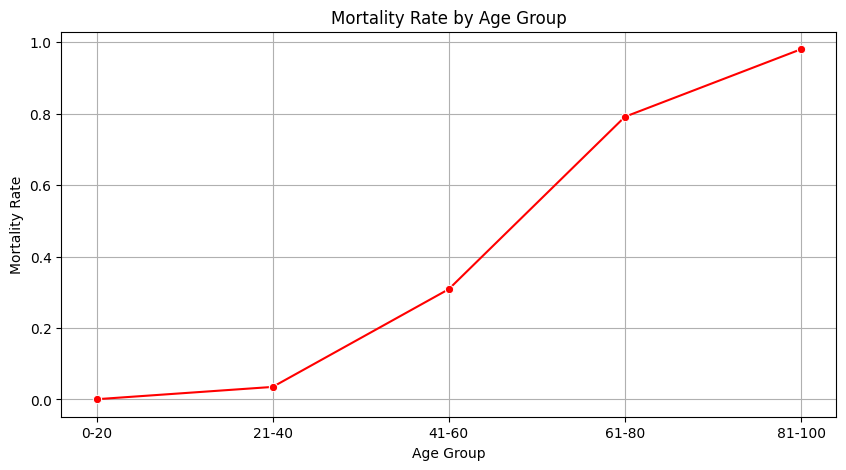

In [7]:
# =========================
# 3. Mortality Rate by Age Group (Changed to a Line Chart)
# =========================
AGE_BINS = [0, 20, 40, 60, 80, 100]
AGE_LABELS = ['0-20', '21-40', '41-60', '61-80', '81-100']
PATIENTS['AGE_GROUP'] = pd.cut(PATIENTS['AGE'], bins=AGE_BINS, labels=AGE_LABELS, include_lowest=True, right=False)
MORTALITY_RATE = PATIENTS.groupby('AGE_GROUP', observed=False)['EXPIRE_FLAG'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=MORTALITY_RATE.index, y=MORTALITY_RATE.values, marker='o', color='red')
plt.title('Mortality Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Mortality Rate')
plt.grid(True)
plt.show()

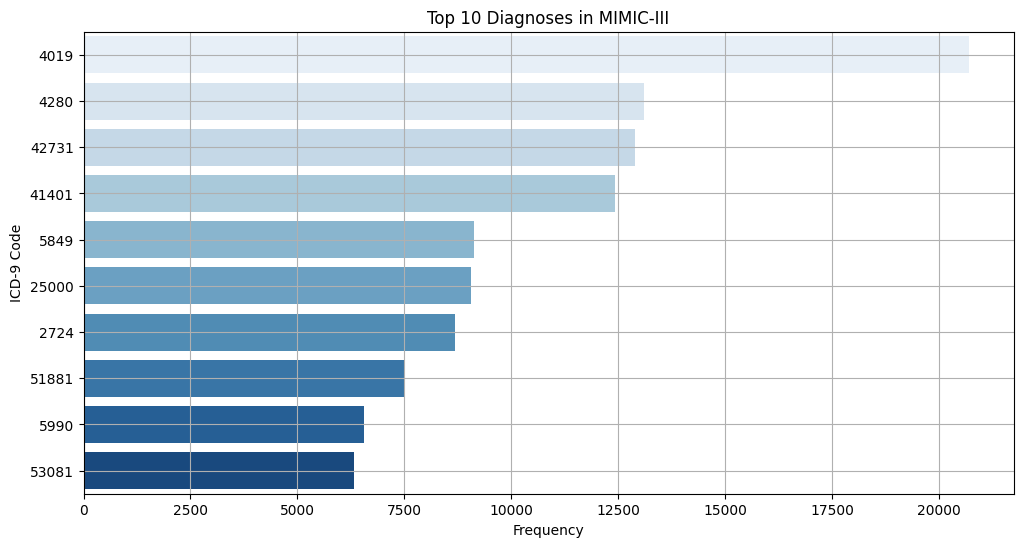

In [8]:
# =========================
# 4. Common Diagnoses Among Patients
# =========================
DIAGNOSES_COUNT = DIAGNOSES['ICD9_CODE'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=DIAGNOSES_COUNT.values, y=DIAGNOSES_COUNT.index, hue=DIAGNOSES_COUNT.index, palette='Blues', legend=False)
plt.title('Top 10 Diagnoses in MIMIC-III')
plt.xlabel('Frequency')
plt.ylabel('ICD-9 Code')
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

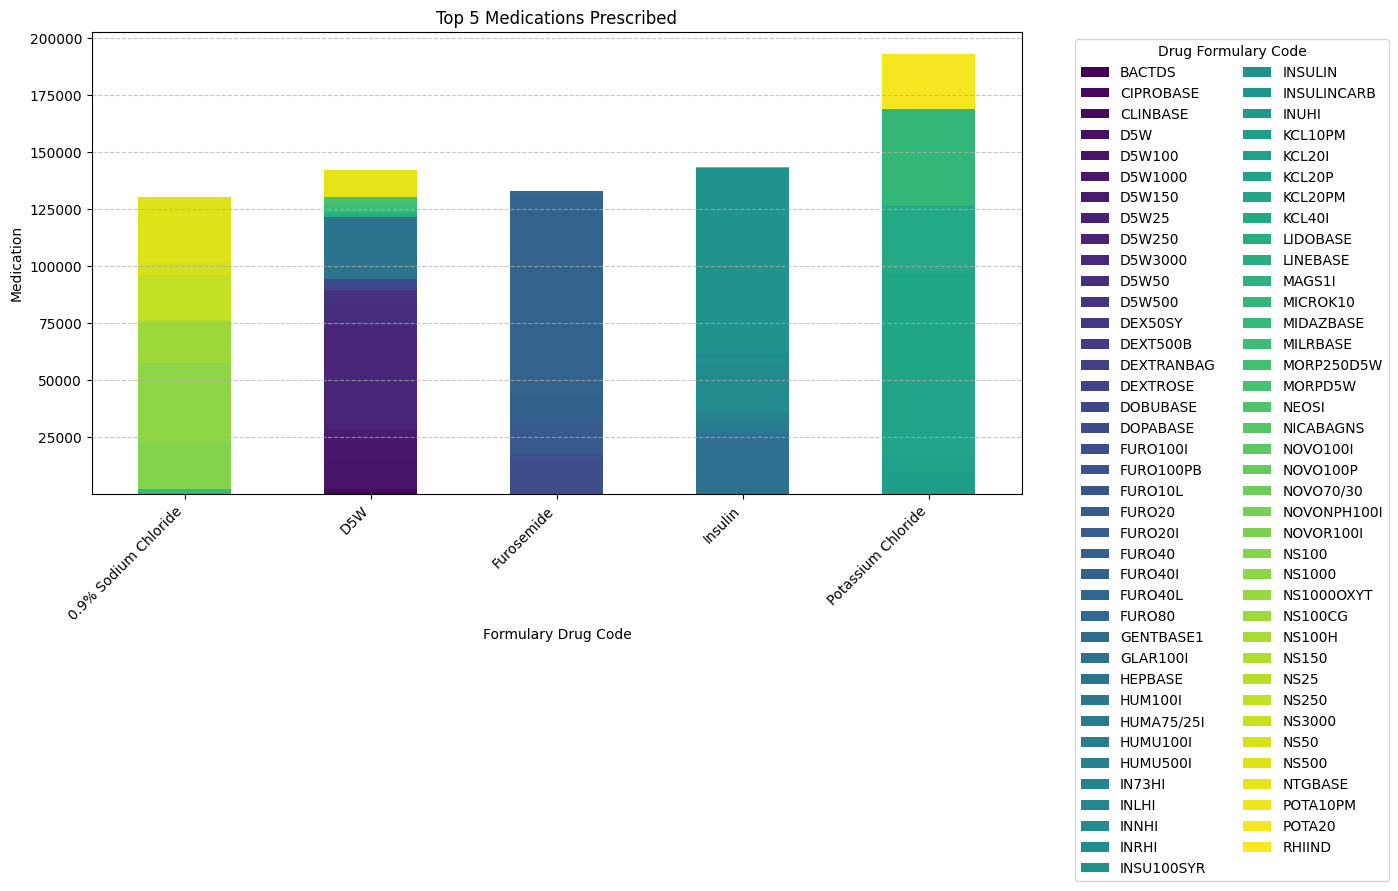

In [9]:
# =========================
# 5. Medication Prescriptions by Drug Type
# =========================
TOP_MEDS = PRESCRIPTIONS['DRUG'].value_counts().head(5).index
MED_COUNTS = PRESCRIPTIONS[PRESCRIPTIONS['DRUG'].isin(TOP_MEDS)].groupby(['DRUG', 'FORMULARY_DRUG_CD']).size().unstack()

plt.figure(figsize=(12, 6))
ax = MED_COUNTS.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6))
plt.xticks(rotation=45, ha='right')
plt.legend(title='Drug Formulary Code', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Top 5 Medications Prescribed')
plt.xlabel('Formulary Drug Code')
plt.ylabel('Medication')
plt.show()

In [17]:
# =========================
# 6. Interactive Admissions by Hour (Using d3.js with a Local Web Server)
# =========================
# Compute number of admissions per hour of the day
ADMISSIONS['HOUR'] = ADMISSIONS['ADMITTIME'].dt.hour
hour_counts = ADMISSIONS['HOUR'].value_counts().sort_index().reset_index()
hour_counts.columns = ['hour', 'admissions']

# Save the hourly counts as JSON for d3 visualization.
hour_counts.to_json("admissions_by_hour.json", orient='records')

# Start a local web server to serve the JSON file.
import threading
import http.server
import socketserver

def start_server(port=8000):
    Handler = http.server.SimpleHTTPRequestHandler
    with socketserver.TCPServer(("", port), Handler) as httpd:
        print(f"Serving at http://localhost:{port}")
        httpd.serve_forever()

# Start the server in a background thread so it doesn't block the notebook.
server_thread = threading.Thread(target=start_server, args=(8000,), daemon=True)
server_thread.start()

print("Local web server started. You can access your JSON at http://localhost:8000/admissions_by_hour.json")

Local web server started. You can access your JSON at http://localhost:8000/admissions_by_hour.json
Serving at http://localhost:8000

In [19]:
import json
from IPython.display import HTML

# Load your JSON data into Python
with open("admissions_by_hour.json", "r") as f:
    data = json.load(f)
data_json = json.dumps(data)  # Convert back to JSON string

# Create the HTML content with the JSON data embedded
html_content = f"""
<!DOCTYPE html>
<html>
<head>
  <meta charset="utf-8">
  <title>Admissions by Hour</title>
  <script src="https://d3js.org/d3.v7.min.js"></script>
  <style>
    .bar {{ fill: steelblue; }}
    .bar:hover {{ fill: orange; }}
    .axis-label {{ font: 12px sans-serif; }}
  </style>
</head>
<body>
<div id="chart"></div>
<script>
  // Embedded data from Python
  const data = {data_json};

  // Set dimensions and margins
  const margin = {{top: 20, right: 30, bottom: 40, left: 40}},
        width = 600 - margin.left - margin.right,
        height = 400 - margin.top - margin.bottom;

  // Create SVG container
  const svg = d3.select("#chart").append("svg")
      .attr("width", width + margin.left + margin.right)
      .attr("height", height + margin.top + margin.bottom)
    .append("g")
      .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

  // Ensure data is properly typed
  data.forEach(d => {{
    d.hour = +d.hour;
    d.admissions = +d.admissions;
  }});

  // X scale: hours (0-23)
  const x = d3.scaleBand()
    .domain(data.map(d => d.hour))
    .range([0, width])
    .padding(0.1);

  svg.append("g")
    .attr("transform", "translate(0," + height + ")")
    .call(d3.axisBottom(x))
    .selectAll("text")
      .attr("class", "axis-label");

  // Y scale: admission counts
  const y = d3.scaleLinear()
    .domain([0, d3.max(data, d => d.admissions)])
    .nice()
    .range([height, 0]);

  svg.append("g")
    .call(d3.axisLeft(y))
    .selectAll("text")
      .attr("class", "axis-label");

  // Draw bars
  svg.selectAll(".bar")
    .data(data)
    .enter().append("rect")
    .attr("class", "bar")
    .attr("x", d => x(d.hour))
    .attr("width", x.bandwidth())
    .attr("y", d => y(d.admissions))
    .attr("height", d => height - y(d.admissions));

  // Add X axis label
  svg.append("text")
    .attr("text-anchor", "middle")
    .attr("x", width / 2)
    .attr("y", height + margin.bottom - 5)
    .text("Hour of Day")
    .attr("class", "axis-label");

  // Add Y axis label
  svg.append("text")
    .attr("text-anchor", "middle")
    .attr("transform", "rotate(-90)")
    .attr("x", -height / 2)
    .attr("y", -margin.left + 15)
    .text("Number of Admissions")
    .attr("class", "axis-label");
</script>
</body>
</html>
"""

HTML(html_content)